# Classify images using data of only 1 user

Take all data from 1 user, split in groups by image id.

Learn to classify True/Fake patches, then combine them into True/Fake images by majority vote.

In [1]:
import os
import numpy as np
import pandas as pd

import skelm

from matplotlib import pyplot as plt
import seaborn as sn
%matplotlib inline

In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [19]:
from sklearn.model_selection import GroupKFold, cross_val_score, GridSearchCV, GroupShuffleSplit, RandomizedSearchCV
import scipy
from sklearn.utils.fixes import loguniform
from time import time
from sklearn.metrics import roc_curve
import pickle

In [4]:
data_folder = "/Users/akusok/wrkdir/research-signatures-data/MCYTDB"
overlap = '90p'
samples = 10000000 // 30   # per file

In [51]:
P = pd.read_parquet("/Users/akusok/wrkdir/research-signatures-data/MCYTDB/0003/overlap50p/cf-0005_0003f08_features.parquet.gz")

In [52]:
P.wsize.value_counts()

64     286
128     65
256     12
Name: wsize, dtype: int64

In [44]:
P.wsize.value_counts()

64     5016
128    1083
256     120
Name: wsize, dtype: int64

# 

## Load data and run default ELM

In [5]:
for _,users,_ in os.walk(data_folder):
    break

In [6]:
def process_user(u0, model):
    
    for root,_,files in os.walk("{}/{}/overlap{}".format(data_folder, u0, overlap)):
        data_files = [os.path.join(root, f) for f in files if f.endswith(".parquet.gz")]
    
    data = []
    for i, df0 in enumerate(data_files):
        X = pd.read_parquet(df0).loc[:, '0':]
        X = X.sample(min(len(X), samples))
        X['fake'] = int("/cf-" in df0)
        X['group'] = i
        data.append(X)
    data = pd.concat(data).reset_index(drop=True)    
    
    group = np.array(data['group'])
    y = np.array(data['fake'])
    X = np.array(data.loc[:, :'1023'])
    X = X - X.mean()
    X = X / X.std().clip(min=0.5)
    X = X.clip(min=-5, max=5)
    
    gkf = GroupKFold(n_splits=10)
    res = []
    for ti, vi in gkf.split(X, y, group):
        model.fit(X[ti], y[ti])
        yh = model.predict(X[vi])
        yv = y[vi]
        gv = group[vi]
        for j in set(gv):
            res.append([j, yv[gv == j].mean(), yh[gv == j].mean()])

    res = np.array(res)
    res = res[np.argsort(res[:,2])]
    return res

# 90p

In [23]:
model = skelm.ELMClassifier(alpha=0.3, n_neurons=1900)
V = []

for i, usr in enumerate(users):
    print(usr, end=' ')
    res = process_user(usr, model)
    V.extend(res)
    with open("res_V_{}.pkl".format(i), "wb") as fout:
        pickle.dump(V, fout)
        
    resA = np.array(res)
    fpr, tpr, threshold = roc_curve(resA[:,1], resA[:,2], pos_label=1)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
    EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    print(EER)

0112 

KeyboardInterrupt: 

#  

## Analysing previous finding 

In [24]:
with open("V_singleuser_results.pkl", "rb") as fin:
    V = pickle.load(fin)

In [38]:
res = np.vstack([v for k,v in V['V10'].items()])
fpr, tpr, threshold = roc_curve(res[:,1], res[:,2], pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
EER

0.07111111111111111

In [40]:
res = np.vstack([v for k,v in V['V50'].items()])
fpr, tpr, threshold = roc_curve(res[:,1], res[:,2], pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
EER

0.035555555555555556

In [41]:
res = np.vstack([v for k,v in V['V90'].items()])
fpr, tpr, threshold = roc_curve(res[:,1], res[:,2], pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
EER

0.02311111111111111

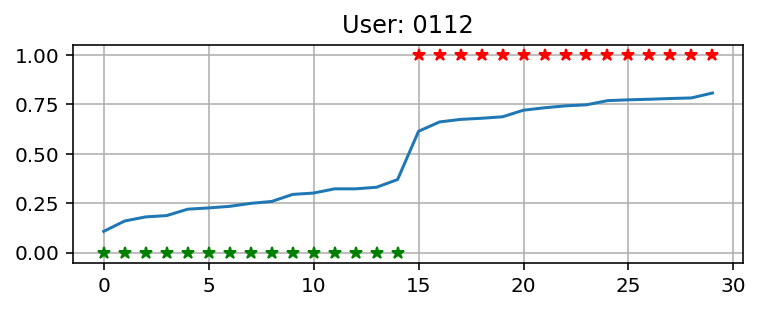

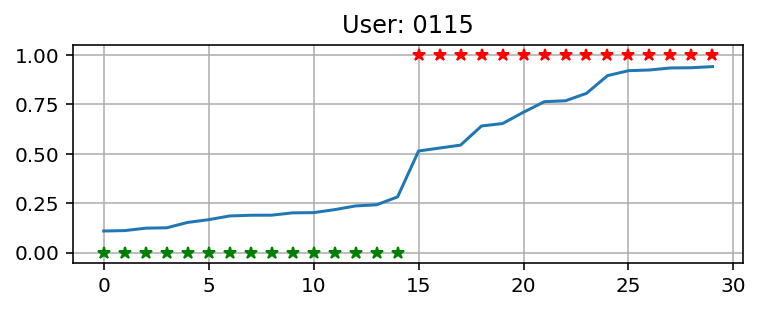

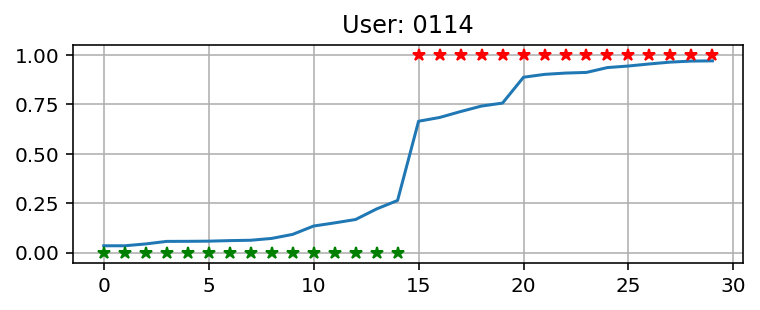

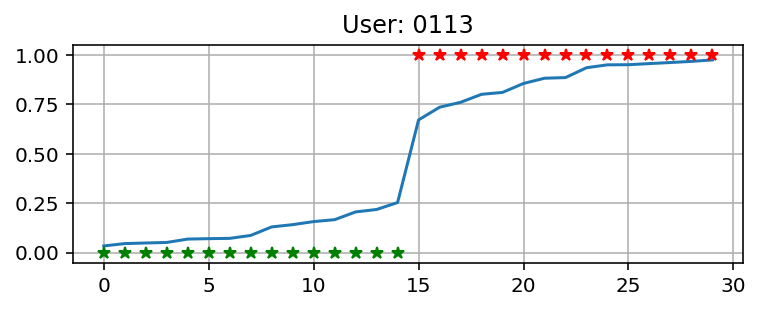

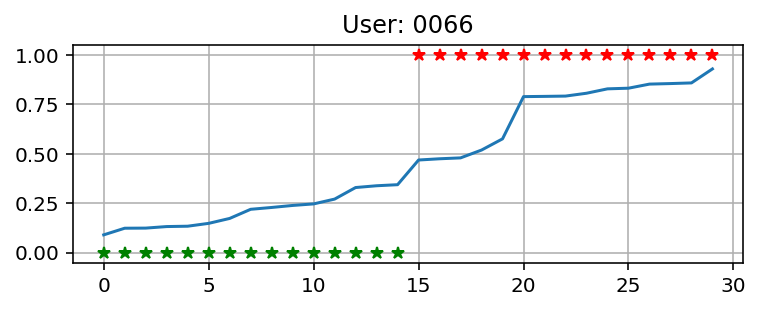

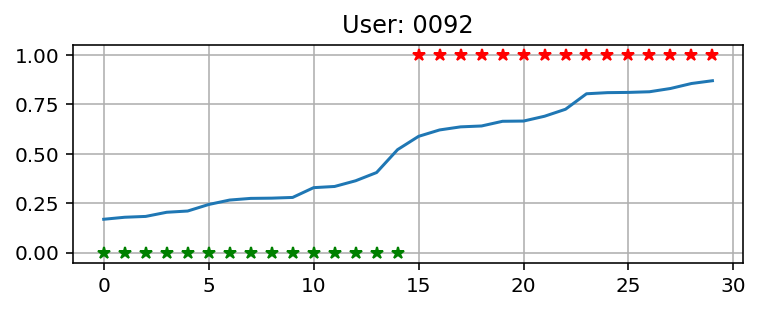

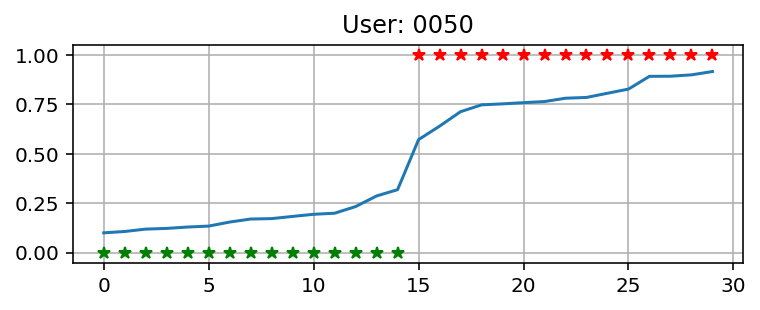

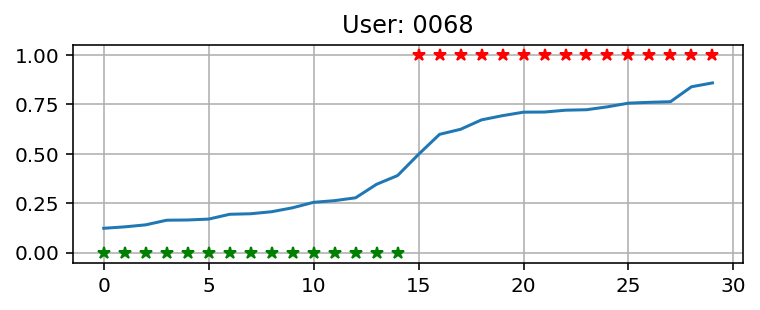

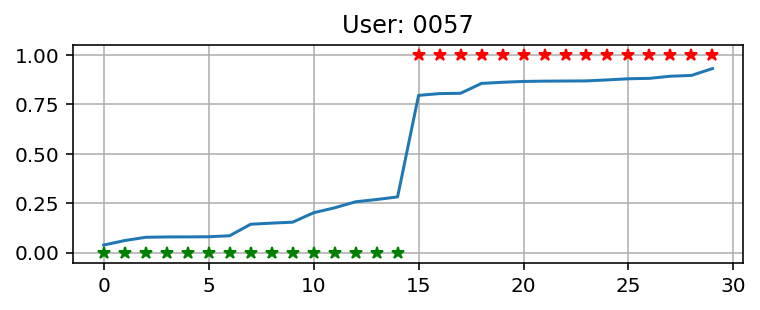

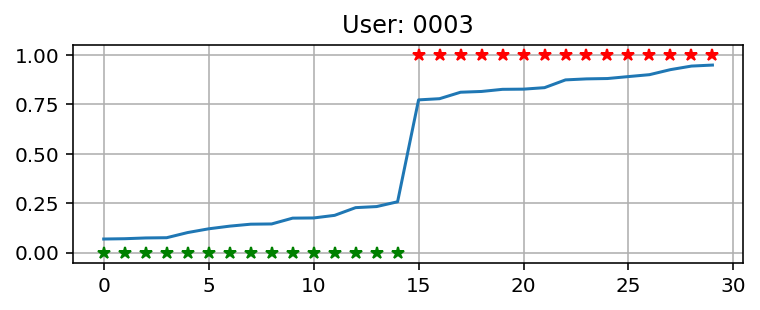

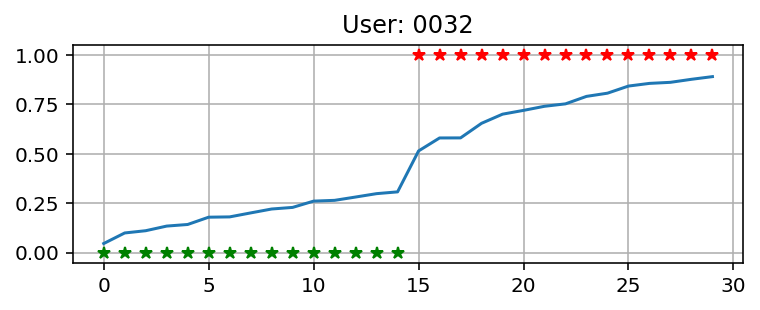

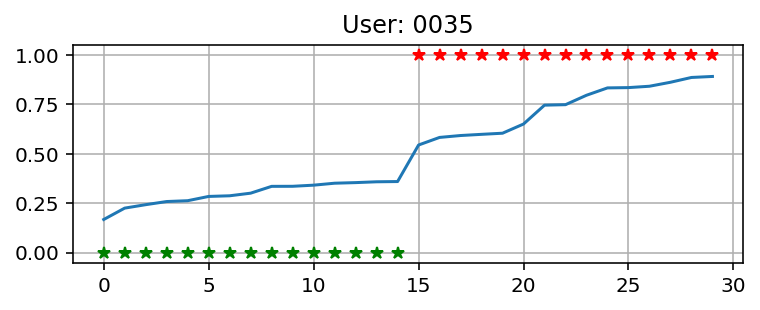

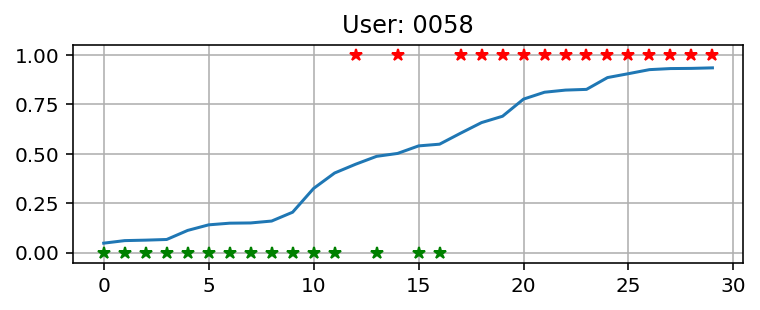

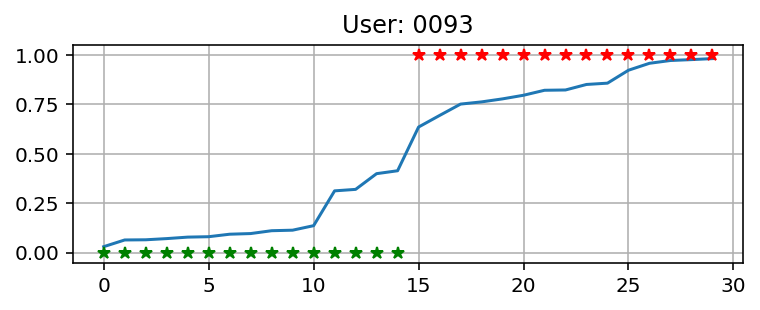

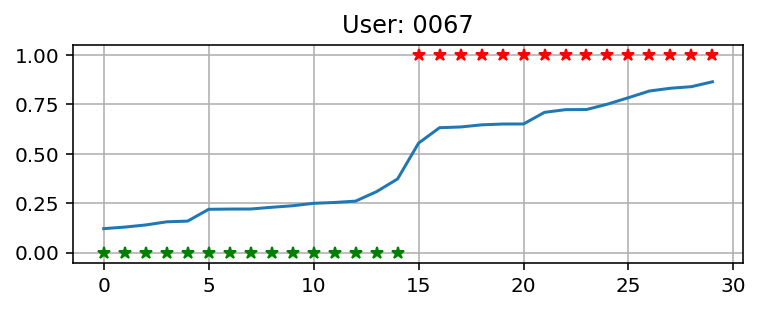

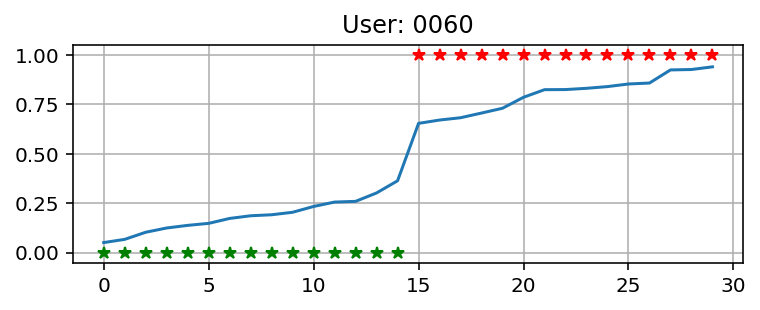

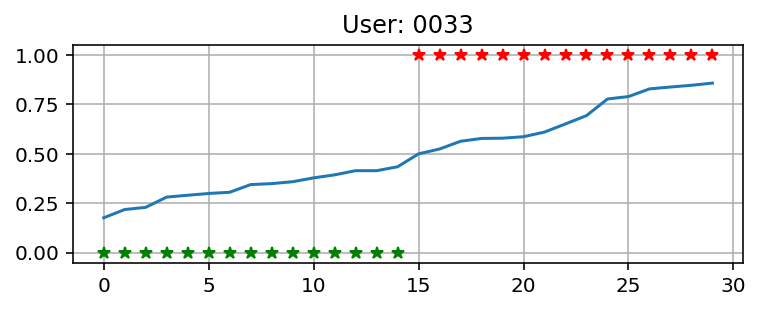

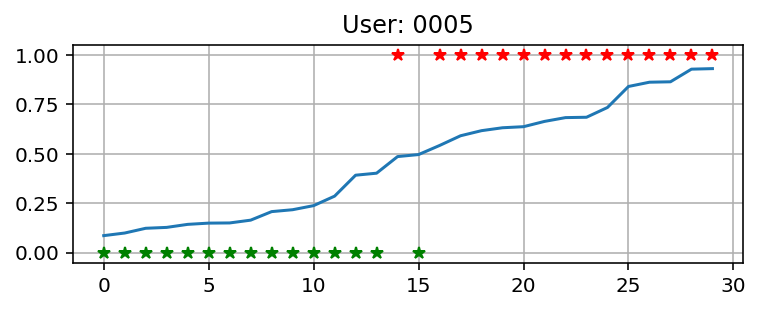

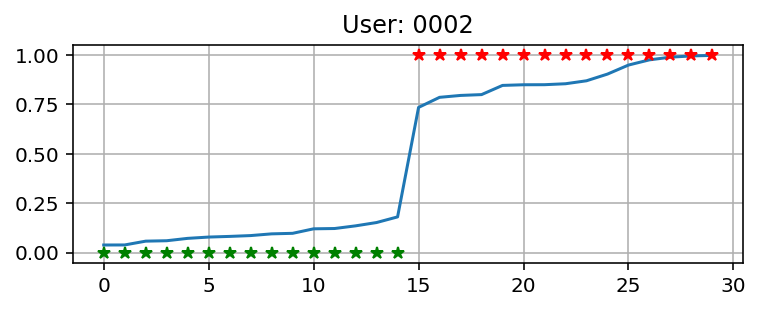

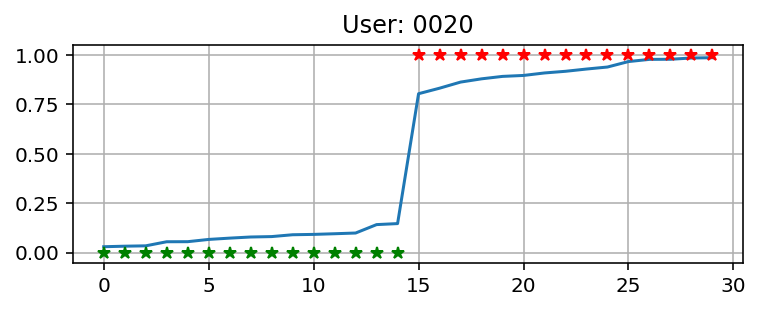

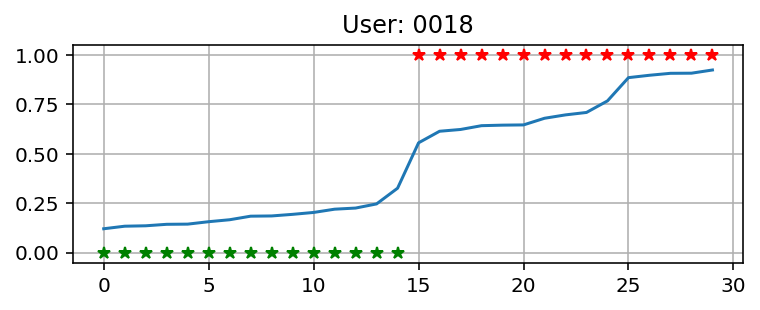

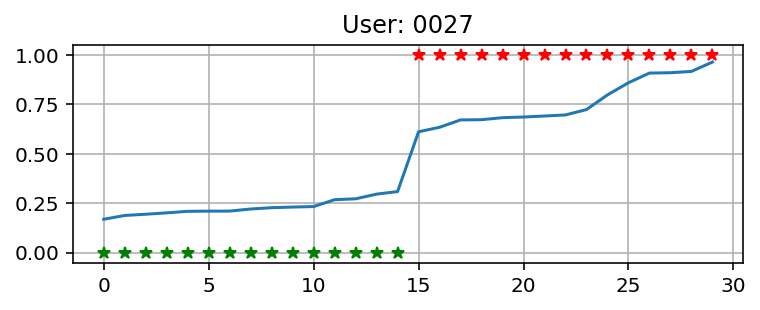

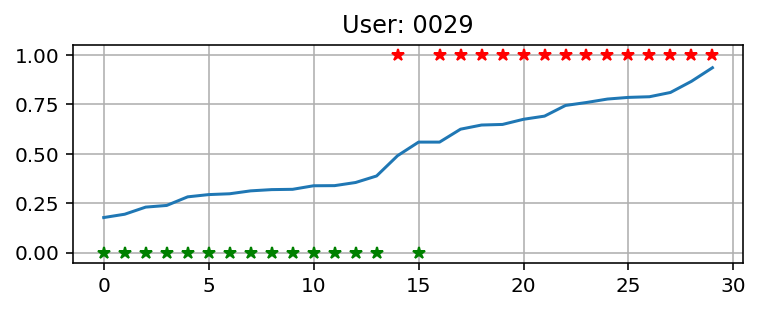

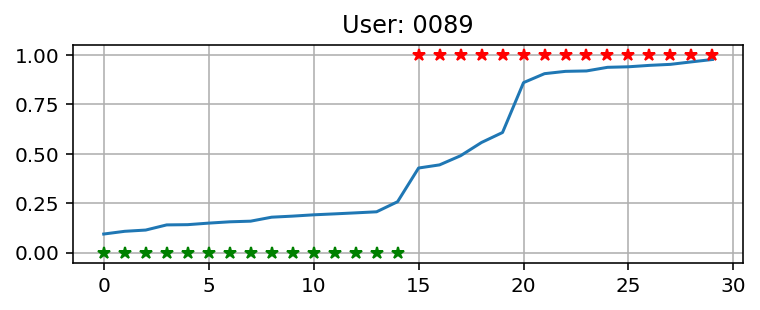

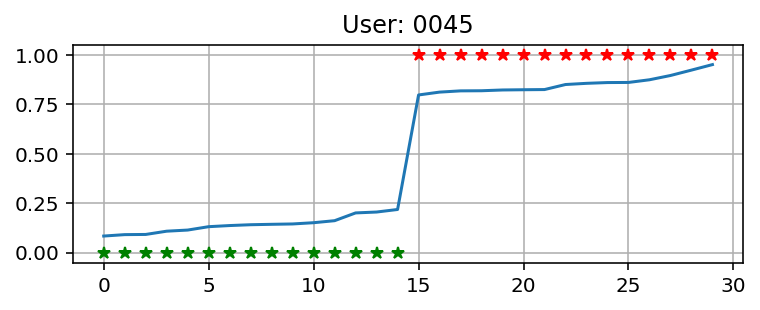

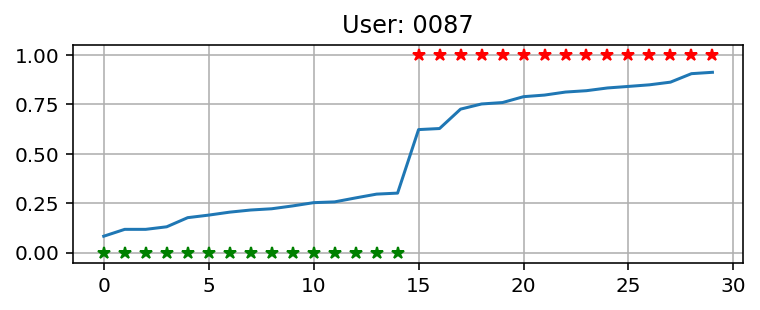

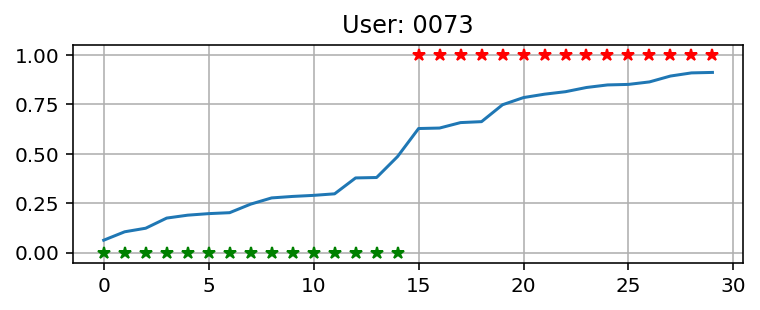

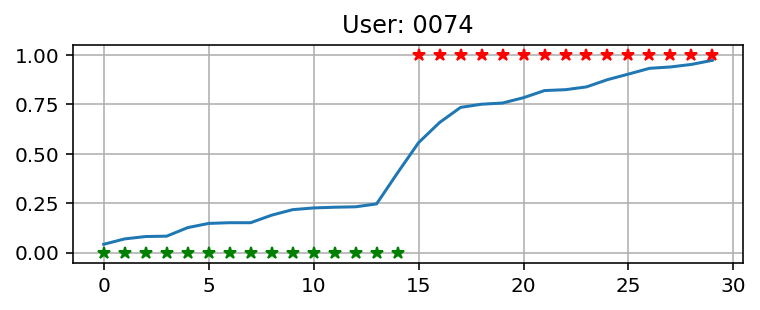

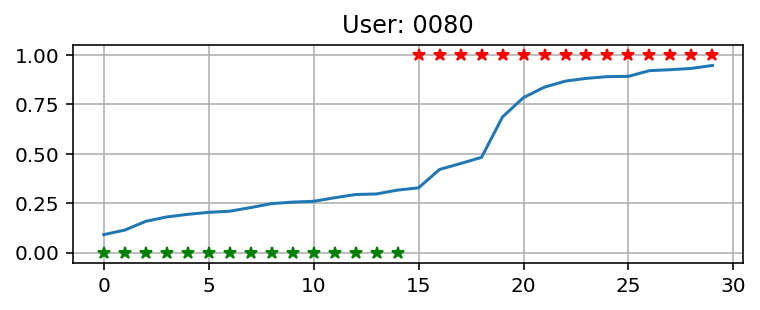

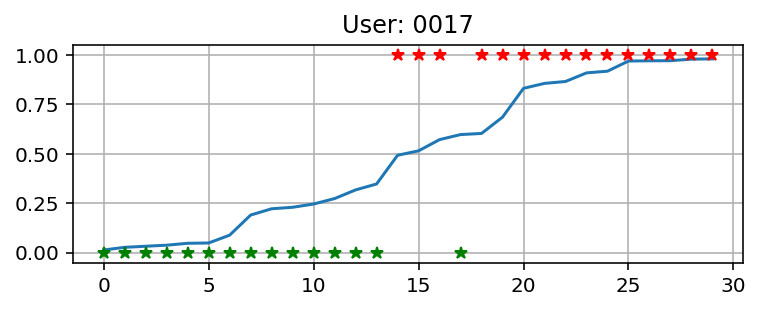

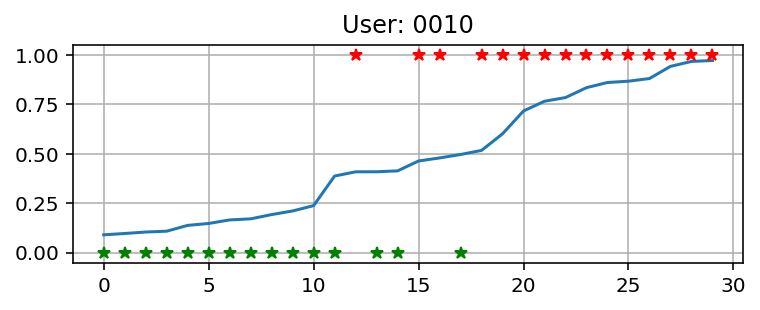

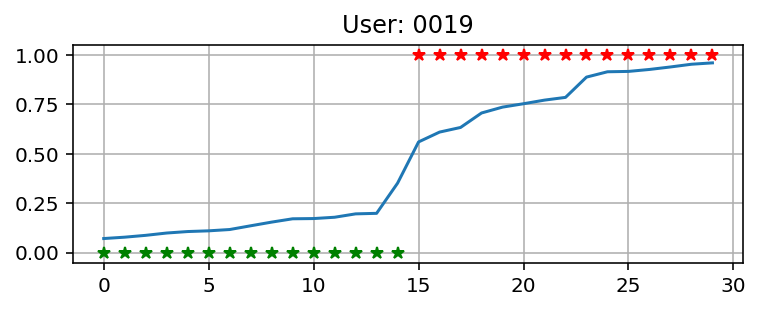

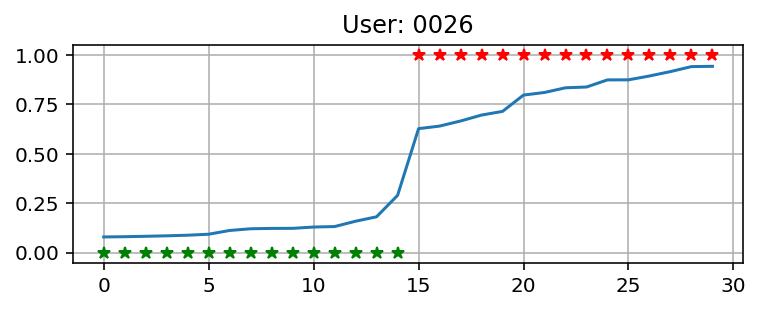

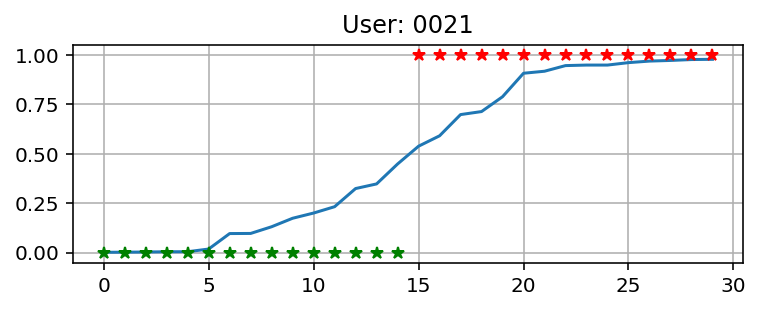

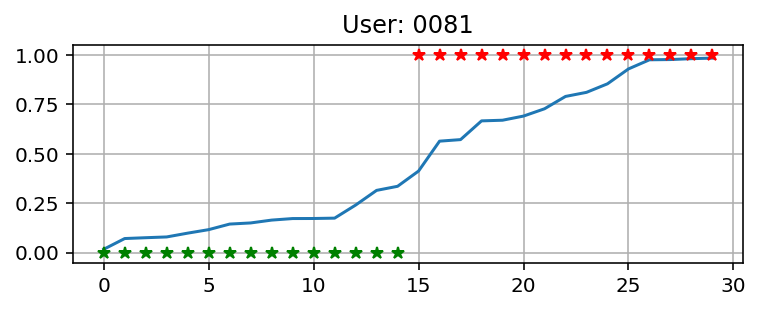

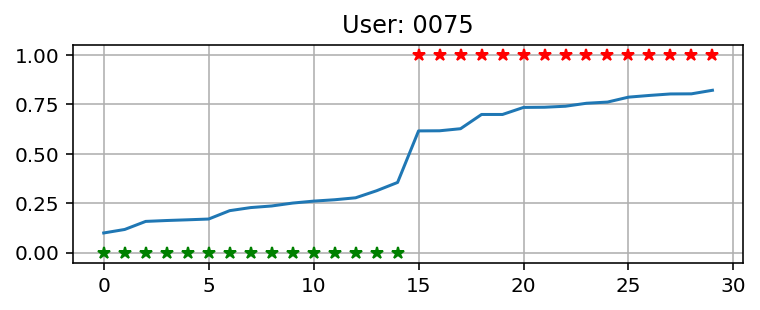

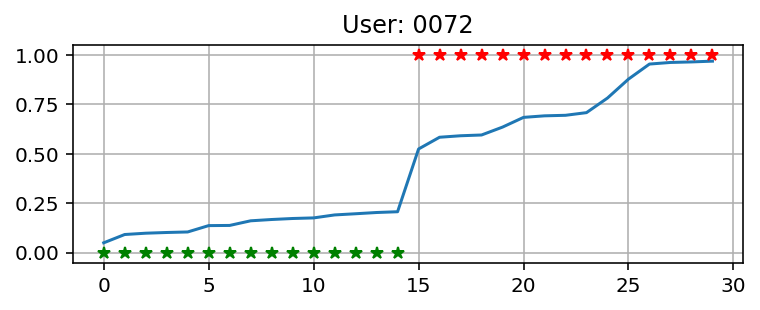

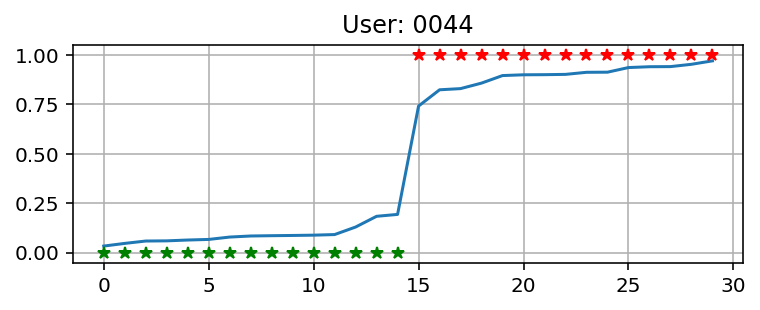

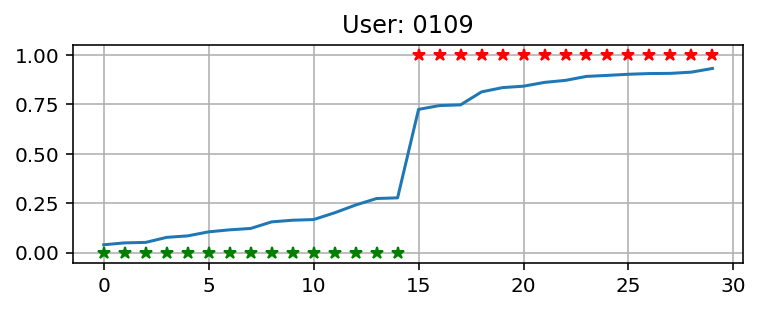

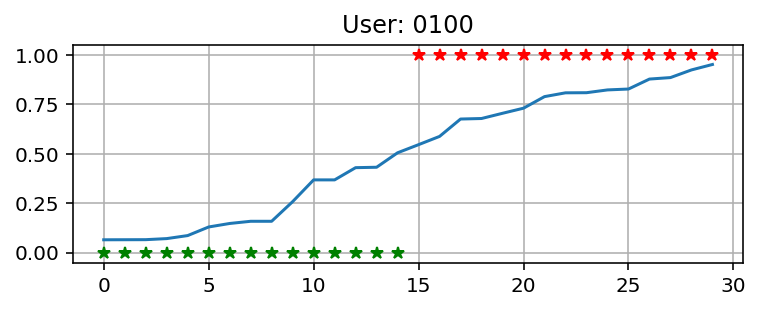

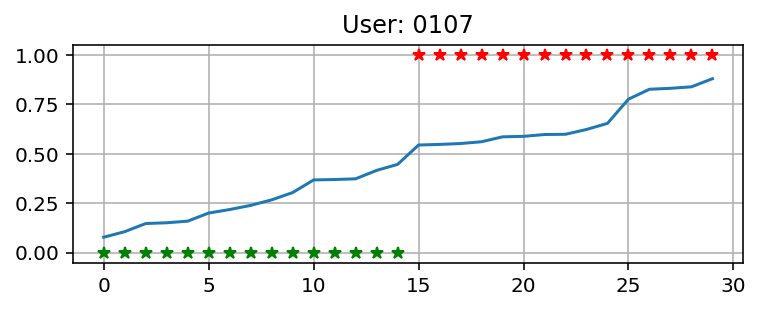

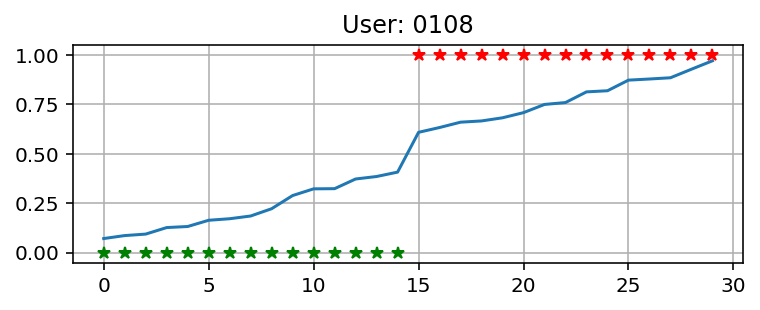

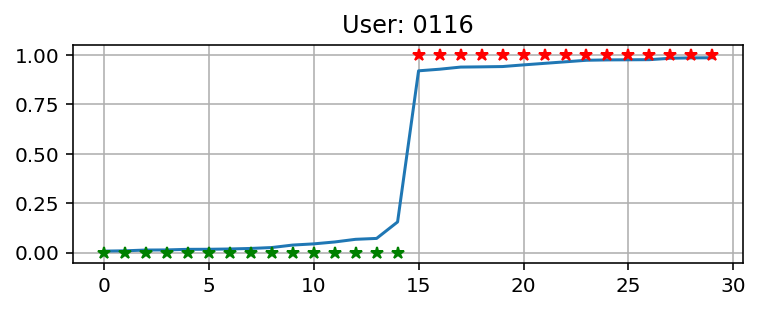

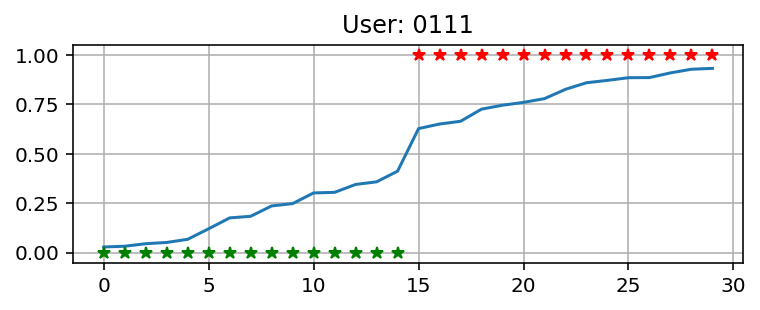

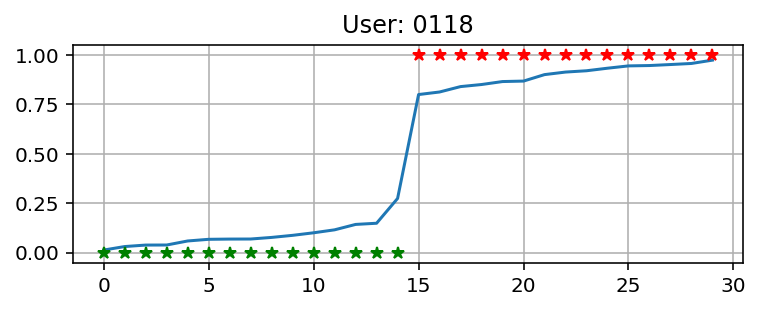

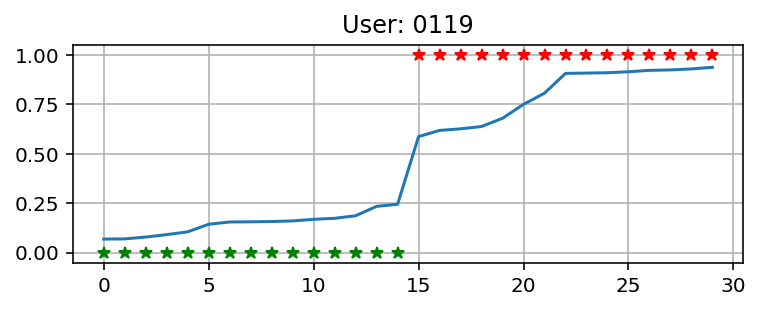

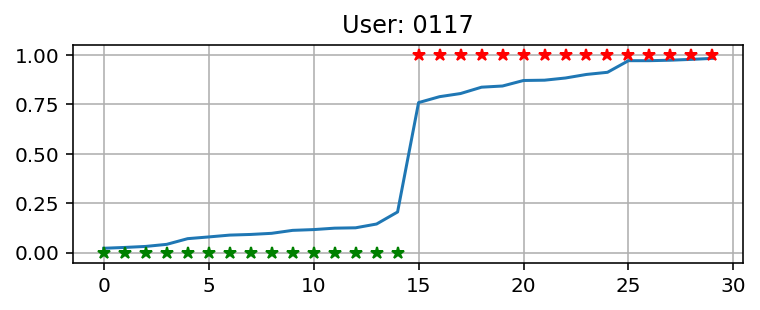

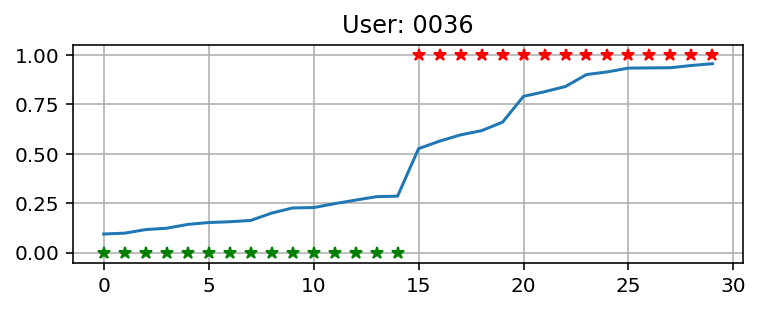

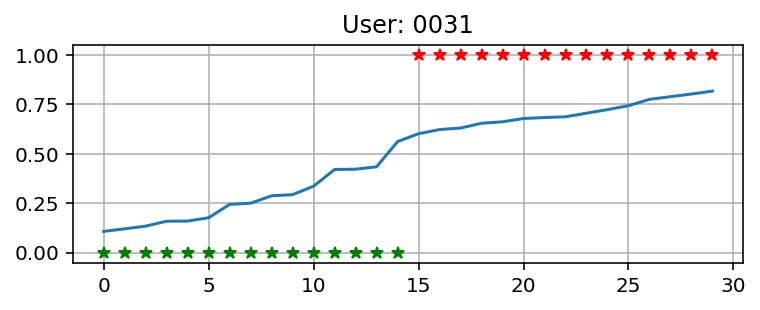

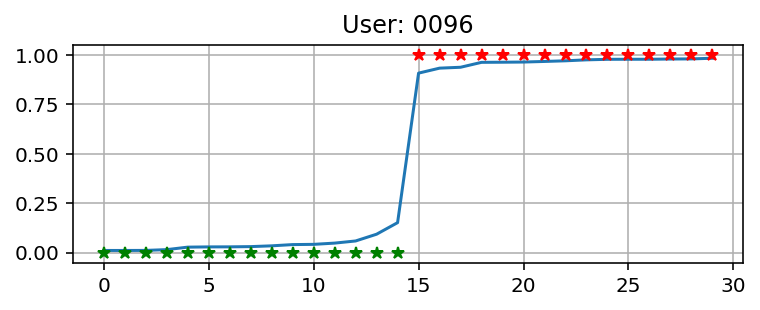

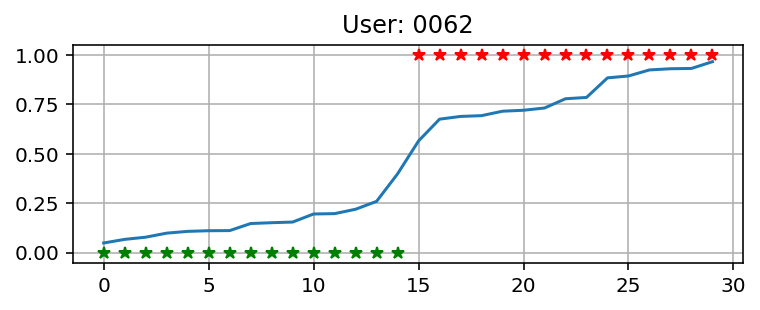

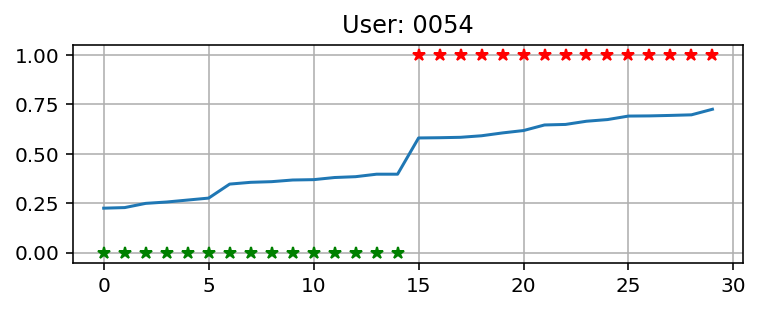

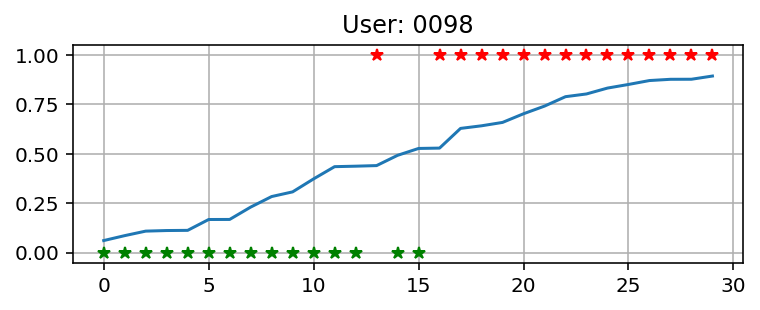

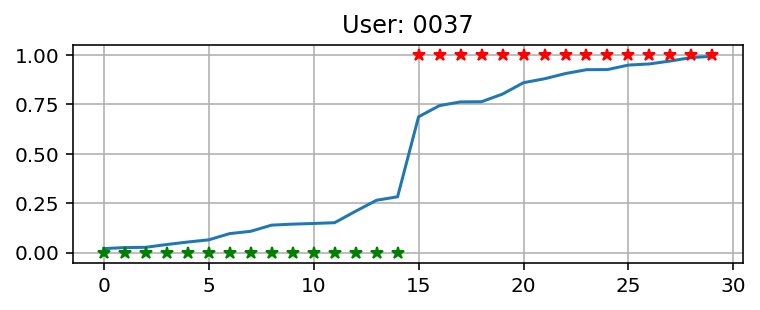

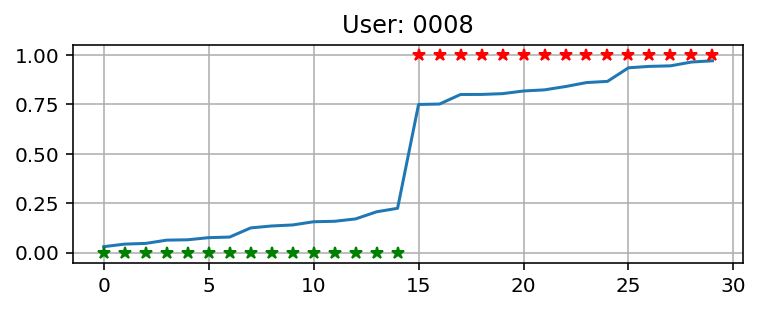

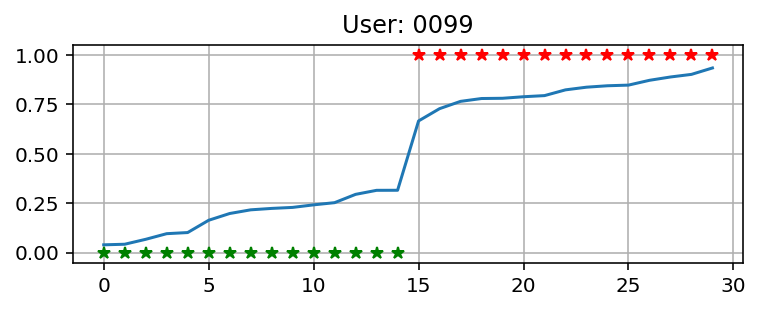

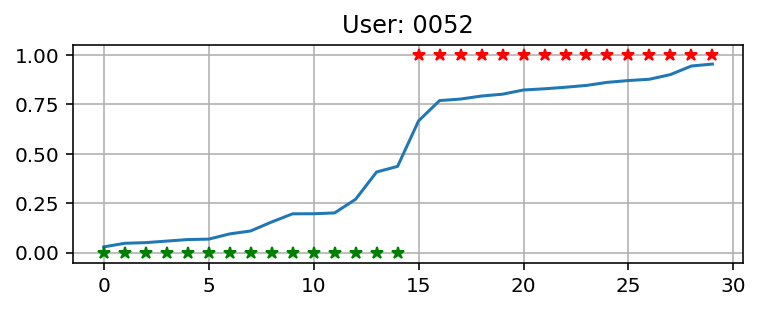

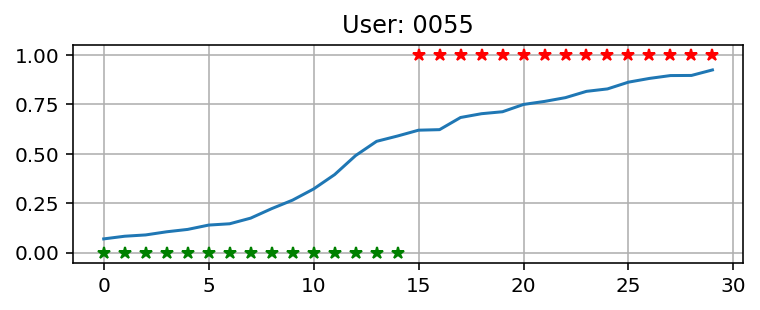

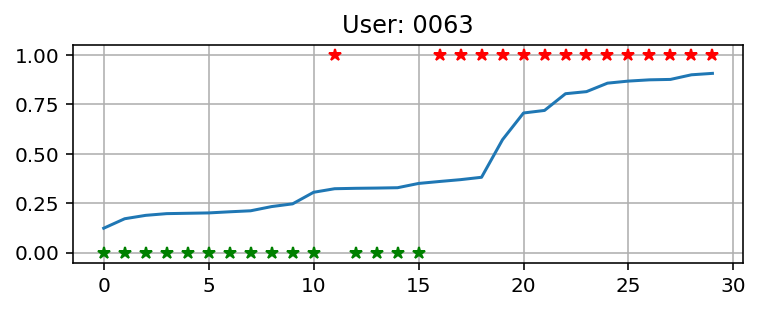

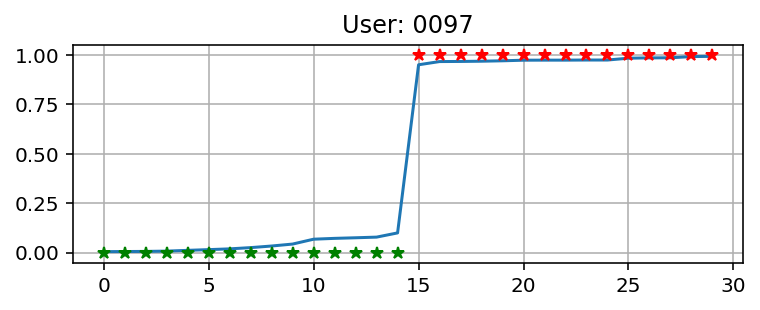

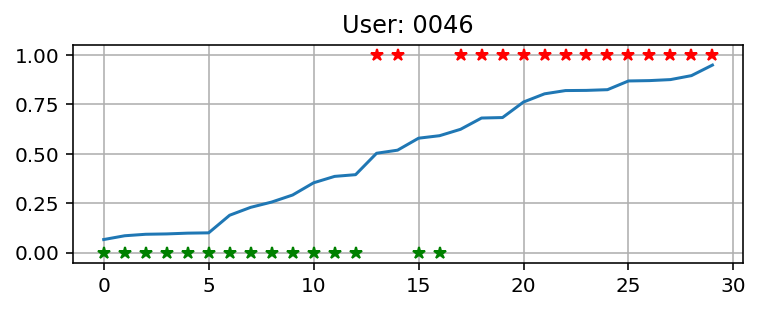

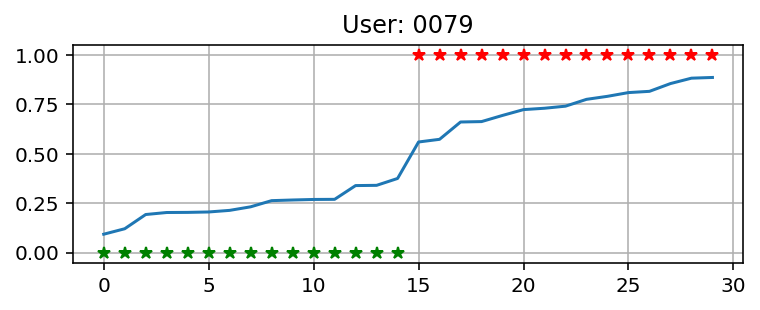

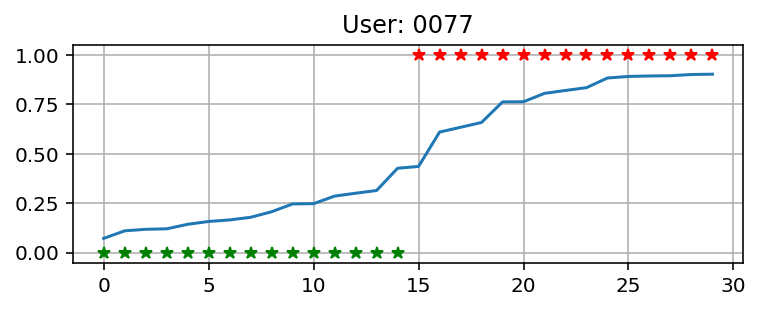

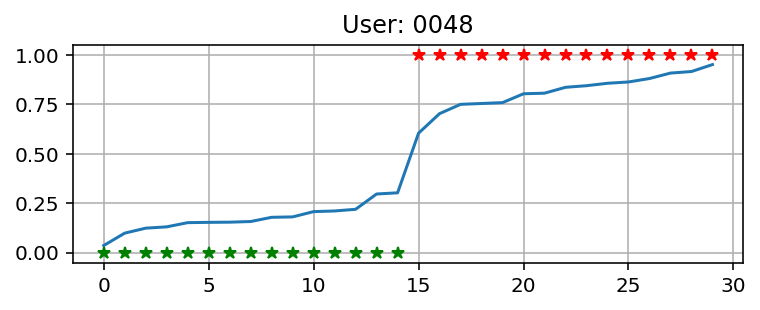

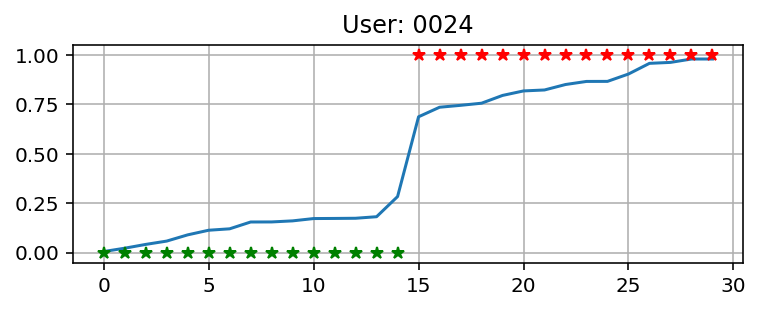

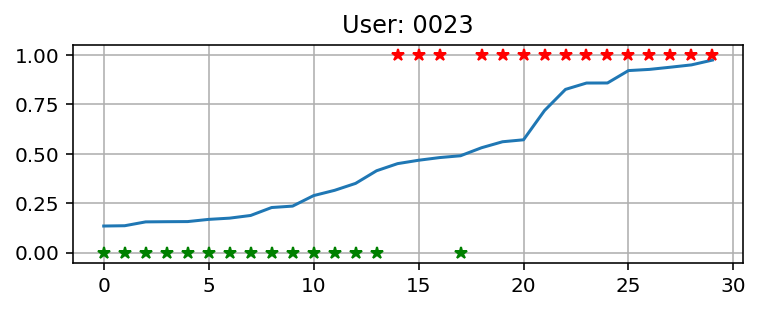

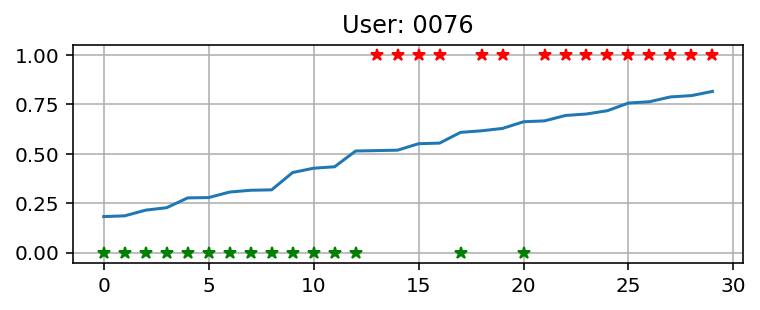

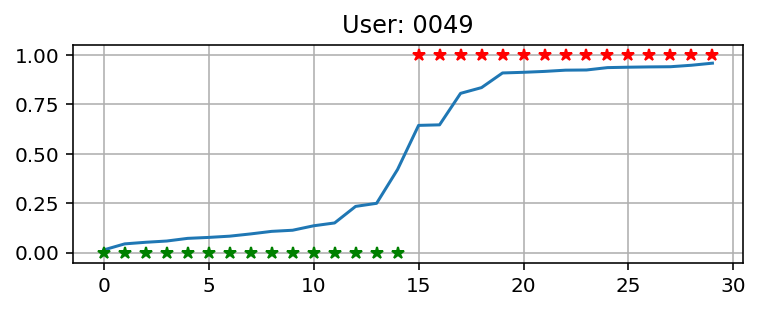

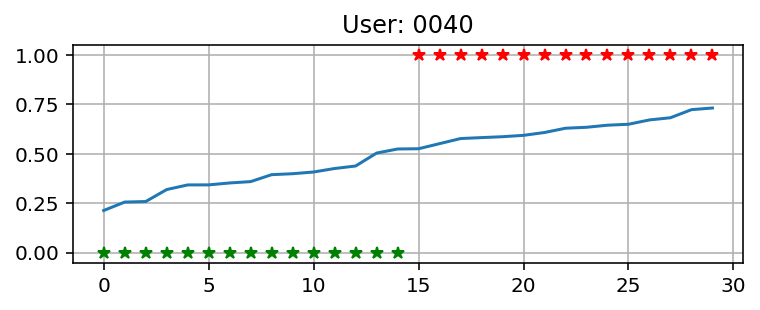

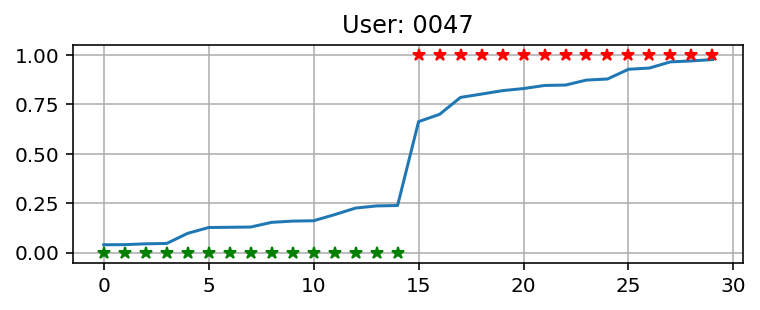

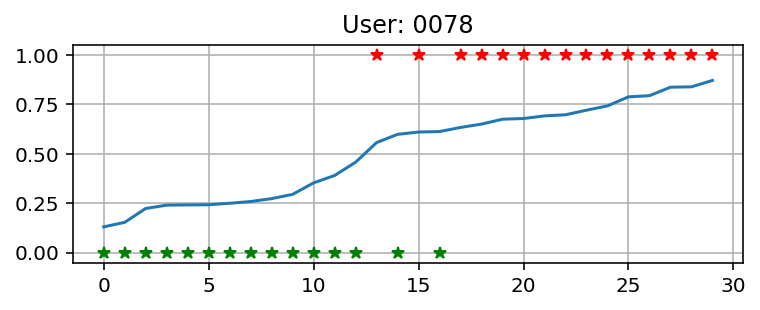

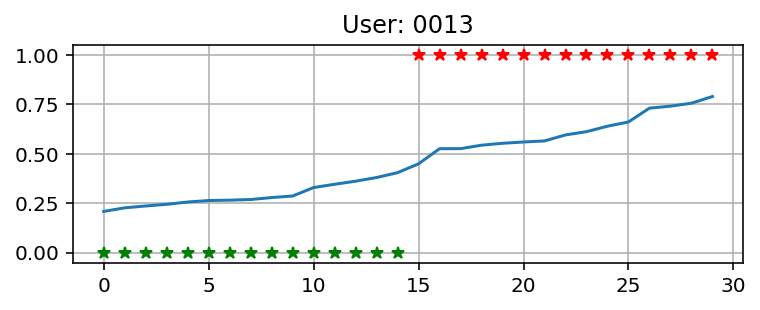

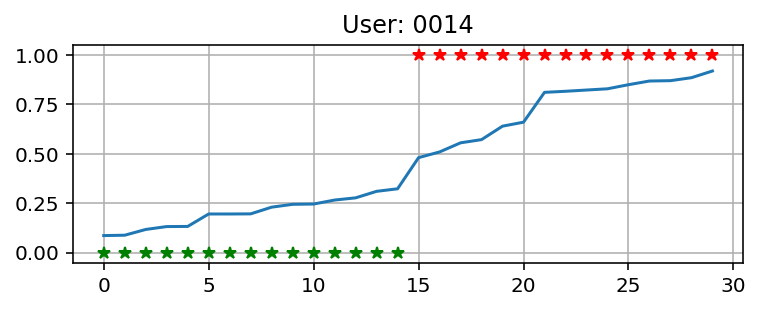

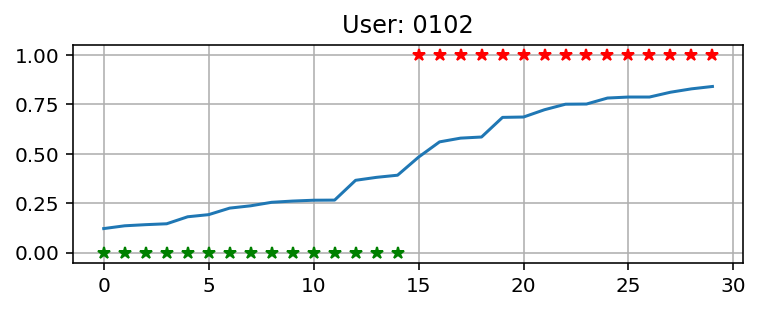

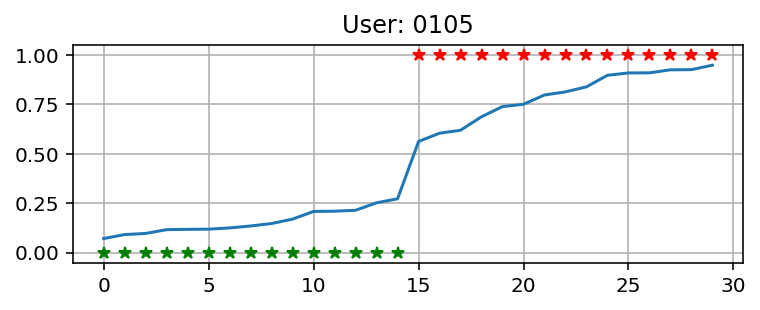

In [8]:
V = {}
model = skelm.ELMClassifier(alpha=0.3, n_neurons=10000)

for usr in users:
    res = process_user(usr, model)
    V[usr] = res
    
    plt.figure(figsize=(6, 2))
    plt.plot(res[:, 2])
    i0 = np.where(res[:, 1] == 0)[0]
    plt.plot(i0, [0]*len(i0), "*g")

    i1 = np.where(res[:, 1] == 1)[0]
    plt.plot(i1, [1]*len(i1), "*r")
    plt.title("User: "+usr)
    plt.grid()
    plt.show()